In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy
sns.set_style('darkgrid')
%matplotlib inline


#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix


#xgboost
import xgboost as xgb

# Initialize Data

In [2]:
data = pd.read_csv("exoplanet_plus_browndwarf.csv")

In [3]:
data.head(5)

,pl_rade,log_pl_orbper,st_teff,pl_class,pl_class2
0,1.875,-0.132799,5172.0,Terrestrial,SuperEarth
1,4.070,0.927524,3588.0,Terrestrial,Neptunian
2,3.240,1.275518,3700.0,Terrestrial,SuperEarth
3,2.578,1.619985,5766.0,Terrestrial,Neptunian
4,16.700,0.178676,5950.0,Jovian,Jovian


In [4]:
data = data.drop(['pl_class2'],axis=1) #Drop Secondary Classification scheme

In [5]:
X = data.iloc[:, 0:3] #continuous variables
y = data.iloc[:, 3:] #labels

In [6]:
#since there are more than 2 labels, one hot encode for XGBoost
le = LabelEncoder()  
y_xg = le.fit_transform(y) #for xgboost

#ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y)
#y = ohe.transform(y) 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Train / Test Split

In [7]:
ts=0.7 #split fraction

#random forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, train_size=ts, shuffle=True)
#XGBoost
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X, y_xg, train_size=ts, shuffle=True)

# Create Random Forest Model

In [8]:
n_estimators = 150

model_rf = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy')

# Create / Prepare XGBoost Model

In [9]:
#Next you need to create the Xgboost specific DMatrix data format from the numpy array. 
dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
dtest = xgb.DMatrix(X_test_xg, label=y_test_xg)

# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
#num_round = 20  # the number of training iterations
num_round = n_estimators # the number of training iterations

# Train Models

In [10]:
model_rf.fit(X_train_rf, y_train_rf)
preds_train_rf = model_rf.predict(X_train_rf)
preds_test_rf = model_rf.predict(X_test_rf)

model_xg = xgb.train(param, dtrain, num_round)
preds_train_xg = model_xg.predict(dtrain)
preds_test_xg = model_xg.predict(dtest)

/var/folders/ny/3twd2wjn4_lcsddswcby5gdc0000gn/T/ipykernel_41335/2372704717.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_rf, y_train_rf)


[15:34:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



# Classification Reports

In [11]:
cm_rf = confusion_matrix(y_test_rf, preds_test_rf)

Heatmap: Random Forest Test


<AxesSubplot:>

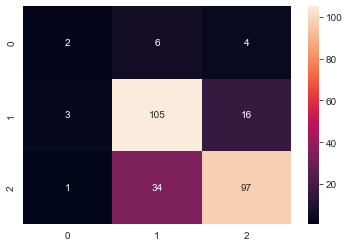

In [12]:
print('Heatmap: Random Forest Test')
sns.heatmap(cm_rf, annot=True, fmt="d")

In [13]:
print('Classification Report: Random Forest Test')
print(classification_report(y_test_rf, preds_test_rf))

Classification Report: Random Forest Test
              precision    recall  f1-score   support

  BrownDwarf       0.33      0.17      0.22        12
      Jovian       0.72      0.85      0.78       124
 Terrestrial       0.83      0.73      0.78       132

    accuracy                           0.76       268
   macro avg       0.63      0.58      0.59       268
weighted avg       0.76      0.76      0.75       268



In [14]:
print('Accuracy Score, Rand. Forest:', accuracy_score(y_test_rf, preds_test_rf))

Accuracy Score, Rand. Forest: 0.7611940298507462


In [15]:
#cm_rf_train = confusion_matrix(y_train_rf, preds_train_rf)

In [16]:
#print('Heatmap: Random Forest')
#sns.heatmap(cm_rf_train, annot=True, fmt="d")

In [17]:
#need to undo label encoder for XGBoost to work in confusion matrix/heatmap etc.
y_test_xg = le.inverse_transform(y_test_xg)

best_preds_test_xg = np.asarray([np.argmax(line) for line in preds_test_xg])
#print("Test precision:", precision_score(y_test, best_preds, average='macro'))
print("XGBoost Test Accuracy:", accuracy_score(y_test_xg, best_preds_test_xg))

best_preds_test_xg = le.inverse_transform(best_preds_test_xg)

XGBoost Test Accuracy: 0.0


In [18]:
cm_xg = confusion_matrix(y_test_xg, best_preds_test_xg)

Heatmap: XGBoost Test


<AxesSubplot:>

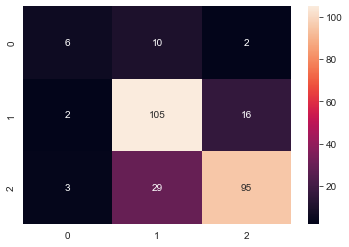

In [19]:
print('Heatmap: XGBoost Test')
sns.heatmap(cm_xg, annot=True, fmt="d")

In [20]:
print('Classification Report: XGBoost Test')
print(classification_report(y_test_xg, best_preds_test_xg))

Classification Report: XGBoost Test
              precision    recall  f1-score   support

  BrownDwarf       0.55      0.33      0.41        18
      Jovian       0.73      0.85      0.79       123
 Terrestrial       0.84      0.75      0.79       127

    accuracy                           0.77       268
   macro avg       0.71      0.65      0.66       268
weighted avg       0.77      0.77      0.76       268



In [21]:
print('Accuracy Score, XGBoost Test:', accuracy_score(y_test_xg, best_preds_test_xg))

Accuracy Score, XGBoost Test: 0.7686567164179104
